# Lab. 3: Momentum I

In this lab we will explore the signal research proccess with the classic Jegadeesh and Titman momentum signal.

We will explore:
- How to compute signals with point in time compliance in mind.
- The need to filter out low priced securities.
- How to create decile and spread portfolios.
- Strategy performance metrics.

## Imports

In [1]:
import sf_quant.data as sfd
import polars as pl
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/kylecm11/silver_fund/sf-quant-labs/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-15 15:42:12,560	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Data

We will be looking at our investment universe from 1996 to 2024.

This should take around 10 seconds to run.

In [2]:
start = dt.date(1996, 1, 1)
end = dt.date(2024, 12, 31)

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
    'market_cap'
]

data = sfd.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

data

date,barrid,ticker,price,return,market_cap
date,str,str,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,6.006157e8
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,6.0865392e8
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,6.0769086e8
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,6.211737e8
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,6.0576474e8
…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9


## Compute the Momentum Signal

## Instructions

- Compute momentum for each security and date as the rolling 230 day return (you can just use log returns here).
- Shift the momentum signal 22 days. This will results in the 11 month return from t-12 to t-2.

In [3]:
def task_compute_momentum(data: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the t_12 to t_2 momentum signal for each secrutiy and date combination.
    
    Args:
        data (pl.DataFrame): Data frame containing date, barrid, price, and return columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    data = data.sort(['barrid', 'date'])
    
    # Calculate momentum using a rolling window
    
    data = data.with_columns(
        (pl.col('return') / 100 + 1).over('barrid').log().rolling_sum(window_size=230).shift(22).alias('momentum')
    )
    
    return data.select(['date', 'barrid', 'price', 'return', 'momentum']).drop_nulls()

momentum = task_compute_momentum(data)

momentum

date,barrid,price,return,momentum
date,str,f64,f64,f64
2014-07-30,"""USA06Z1""",7.1,0.9957,0.101525
2014-07-31,"""USA06Z1""",6.91,-2.6761,0.124505
2014-08-01,"""USA06Z1""",6.81,-1.4472,0.167176
2014-08-04,"""USA06Z1""",7.08,3.9648,0.159344
2014-08-05,"""USA06Z1""",7.05,-0.4237,0.14279
…,…,…,…,…
2024-12-24,"""USBQOR1""",70.58,2.5872,-0.197908
2024-12-26,"""USBQOR1""",73.61,4.293,-0.12738
2024-12-27,"""USBQOR1""",69.85,-5.108,-0.18634


## Price and Momentum Filter

When doing backtesting strategies it's helpful to drop securities with a price below $5.

- Create a variable price_lag that is the previous days price for each security.
- Filter securities to ones with a lagged price greater than 5.
- Drop null momentum values since we won't trade securities where we don't have a signal.

In [4]:
def task_price_filter(momentum: pl.DataFrame) -> pl.DataFrame:
    """
    Filter the universe to lagged price greater than 5 and non-null momentum.
    
    Args:
        momentum (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """

    momentum = momentum.with_columns(
        pl.col('price').shift(1).alias('lagged_price')
    )
    return momentum.filter(
        (pl.col('lagged_price') > 5) & pl.col('momentum').is_not_null()
    ).select(['date', 'barrid', 'price', 'return', 'momentum'])
    

price_filter = task_price_filter(momentum)

price_filter

date,barrid,price,return,momentum
date,str,f64,f64,f64
2014-07-31,"""USA06Z1""",6.91,-2.6761,0.124505
2014-08-01,"""USA06Z1""",6.81,-1.4472,0.167176
2014-08-04,"""USA06Z1""",7.08,3.9648,0.159344
2014-08-05,"""USA06Z1""",7.05,-0.4237,0.14279
2014-08-06,"""USA06Z1""",6.98,-0.9929,0.144795
…,…,…,…,…
2024-12-24,"""USBQOR1""",70.58,2.5872,-0.197908
2024-12-26,"""USBQOR1""",73.61,4.293,-0.12738
2024-12-27,"""USBQOR1""",69.85,-5.108,-0.18634


## Create Decile Portfolios

### Instructions

- For each date divide all securities into 10 deciles based on their momentum score. The highest momentum securities should be in bin 9 and the lowest momentum securities should be in bin 0. The `.qcut()` expression will be helpful here.


In [25]:
def task_momentum_bins(price_filter: pl.DataFrame) -> pl.DataFrame:
    """
    Bin the securities into deciles for each date by momentum.
    
    Args:
        price_filter (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, momentum and bin columns.
    """
    return price_filter.with_columns(pl.col('momentum').over('date').qcut(10, labels=[f"{i}" for i in range(10)]).alias('bin')).sort(['date', 'bin'])
                                     

momentum_bins = task_momentum_bins(price_filter)

momentum_bins

date,barrid,price,return,momentum,bin
date,str,f64,f64,f64,cat
1996-01-02,"""USACKV1""",34.875,-0.3571,-0.609765,"""0"""
1996-01-02,"""USAMWI1""",11.75,-2.0833,-2.807126,"""0"""
1996-01-02,"""USAQRL1""",32.125,0.3906,-0.777146,"""0"""
1996-01-02,"""USAQ8N1""",27.25,1.8692,-0.830929,"""0"""
1996-01-02,"""USALOL1""",22.75,-2.1505,-0.661069,"""0"""
…,…,…,…,…,…
2024-12-31,"""USBDL91""",203.36,-3.4149,1.571995,"""9"""
2024-12-31,"""USANEO1""",78.4,-0.5959,0.693851,"""9"""
2024-12-31,"""USAVLJ1""",44.46,1.368,0.783054,"""9"""


## Equal Weight Portfolios

For each date and bin combo compute the equal weight return.

### Instructions
- Use `.group_by()` to find the average return for each decile on each date.
- Pivot the data frame into index=date, columns=bins, and values=returns (`.pivot()`)
- Compute the spread portfolio as the return of bin 9 minus the return of bin 0

In [29]:
def task_equal_weight_portfolios(momentum_bins: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_bins (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date as the index, bins as the columns, and returns as the values.
    """
    return momentum_bins.group_by(['date', 'bin']).agg(
        pl.col('return').mean().alias('equal_weight_return')
    ).sort(['date', 'bin']).pivot(
        index='date',
        columns='bin',
        values='equal_weight_return'
    ).with_columns((pl.col('9') - pl.col('0')).alias('spread'))

momentum_portfolios = task_equal_weight_portfolios(momentum_bins)

momentum_portfolios

/tmp/ipykernel_3698874/1807670846.py:13: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  ).sort(['date', 'bin']).pivot(


date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-01-02,0.715943,0.696204,0.573414,0.479062,0.536033,0.955142,0.635341,0.00603,0.645837,0.758831,0.042888
1996-01-03,-0.373916,-0.403146,-0.079679,0.077896,-0.210699,-0.517597,0.094406,-0.212747,-0.357763,-0.410821,-0.036905
1996-01-04,-0.965347,-1.049455,-1.056988,-0.664057,-0.927356,-1.267103,-1.069757,-1.151639,-1.322804,-1.225223,-0.259876
1996-01-05,0.370512,0.289178,0.130209,0.493661,0.431043,0.546098,0.4249,0.48049,0.256326,0.347125,-0.023387
1996-01-08,0.042615,-0.027866,0.039135,0.162525,-0.017807,0.017171,0.012718,-0.035134,0.076618,-0.001166,-0.043781
…,…,…,…,…,…,…,…,…,…,…,…
2024-12-24,0.787503,0.852381,0.82585,0.855468,0.656347,0.777991,0.84517,0.848264,1.087551,1.396209,0.608705
2024-12-26,1.908519,1.114878,0.780565,0.669083,0.53989,0.480006,0.425792,0.376766,0.749281,1.170198,-0.73832
2024-12-27,-1.548518,-1.278446,-1.183128,-1.134383,-1.059008,-1.184253,-1.225445,-1.221995,-1.388803,-2.001595,-0.453077


## Portfolio Returns

Compute the cumulative returns of each bin.

### Instructions
- Use the `.unpivot()` method to put our data frame back into long format.
- Compute the cumulative log return.
- Put the return columns into percent space by multiplying by 100.

In [30]:
def task_cumulative_returns(momentum_portfolios: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_portfolios (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date, bin, return, and cumulative_log_return columns.
    """
    return momentum_portfolios.unpivot(index='date', variable_name='bin', value_name='equal_weight_return').with_columns(
        ((pl.col("equal_weight_return") / 100 + 1).log()
         .cum_sum().over("bin"))
        .alias("cumulative_log_return")
    )


momentum_returns = task_cumulative_returns(momentum_portfolios)

momentum_returns

date,bin,equal_weight_return,cumulative_log_return
date,str,f64,f64
1996-01-02,"""0""",0.715943,0.007134
1996-01-03,"""0""",-0.373916,0.003388
1996-01-04,"""0""",-0.965347,-0.006313
1996-01-05,"""0""",0.370512,-0.002614
1996-01-08,"""0""",0.042615,-0.002188
…,…,…,…
2024-12-24,"""spread""",0.608705,3.872603
2024-12-26,"""spread""",-0.73832,3.865192
2024-12-27,"""spread""",-0.453077,3.860651


## Performance Analysis

### Instructions
- Chart the cumulative log returns of the 10 decile portfolios and the spread portfolio.
- Create a table with average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for each portfolio.

<Axes: xlabel='date', ylabel='cumulative_log_return'>

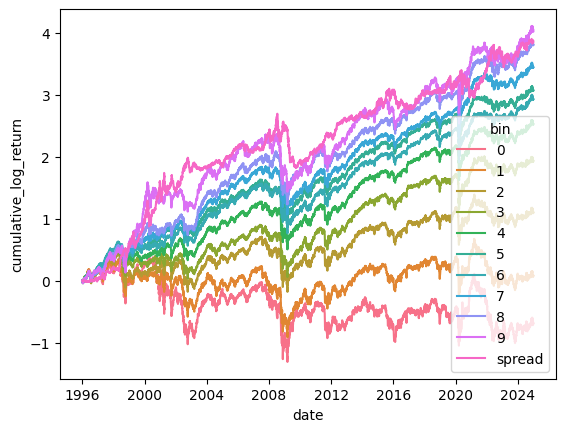

In [31]:
sns.lineplot(data=momentum_returns, x='date', y='cumulative_log_return', hue='bin')

In [32]:
print(momentum_returns.filter(pl.col('bin') == 'spread').select(pl.col('equal_weight_return').mean()).item())
print(momentum_returns.filter(pl.col('bin') == 'spread'))

0.06042431959280947
shape: (7_300, 4)
┌────────────┬────────┬─────────────────────┬───────────────────────┐
│ date       ┆ bin    ┆ equal_weight_return ┆ cumulative_log_return │
│ ---        ┆ ---    ┆ ---                 ┆ ---                   │
│ date       ┆ str    ┆ f64                 ┆ f64                   │
╞════════════╪════════╪═════════════════════╪═══════════════════════╡
│ 1996-01-02 ┆ spread ┆ 0.042888            ┆ 0.000429              │
│ 1996-01-03 ┆ spread ┆ -0.036905           ┆ 0.00006               │
│ 1996-01-04 ┆ spread ┆ -0.259876           ┆ -0.002542             │
│ 1996-01-05 ┆ spread ┆ -0.023387           ┆ -0.002776             │
│ 1996-01-08 ┆ spread ┆ -0.043781           ┆ -0.003214             │
│ …          ┆ …      ┆ …                   ┆ …                     │
│ 2024-12-24 ┆ spread ┆ 0.608705            ┆ 3.872603              │
│ 2024-12-26 ┆ spread ┆ -0.73832            ┆ 3.865192              │
│ 2024-12-27 ┆ spread ┆ -0.453077           ┆ 3.8606

In [33]:
def performance_metrics(returns: pl.DataFrame) -> dict:
    average_return = returns.select(pl.col('return').mean()).item() * np.sqrt(252)
    volatility = returns.select(pl.col('return').std()).item() * np.sqrt(252)
    sharpe = average_return / volatility * np.sqrt(252)

    return {
        'average_return': average_return,
        'volatility': volatility,
        'sharpe': sharpe
    }

for i in range(10):
    print(f"Bin {i}: {performance_metrics(momentum_returns.filter(pl.col('bin') == str(i)).with_columns(pl.col('equal_weight_return').alias('return')))}")

print(f"Spread: {performance_metrics(momentum_returns.filter(pl.col('bin') == 'spread').with_columns(pl.col('equal_weight_return').alias('return')))}")


Bin 0: {'average_return': np.float64(0.138483379250963), 'volatility': np.float64(30.26571906206896), 'sharpe': np.float64(0.07263516484689997)}
Bin 1: {'average_return': np.float64(0.21119107369609058), 'volatility': np.float64(24.797753581113987), 'sharpe': np.float64(0.13519588981046785)}
Bin 2: {'average_return': np.float64(0.3905651154963326), 'volatility': np.float64(21.903256156398257), 'sharpe': np.float64(0.28306426012700275)}
Bin 3: {'average_return': np.float64(0.5475824527205125), 'volatility': np.float64(20.16542147513442), 'sharpe': np.float64(0.4310647294888548)}
Bin 4: {'average_return': np.float64(0.6668575217025857), 'volatility': np.float64(19.33721904340435), 'sharpe': np.float64(0.5474435052044438)}
Bin 5: {'average_return': np.float64(0.7815942842680921), 'volatility': np.float64(19.067620628237595), 'sharpe': np.float64(0.6507064964132433)}
Bin 6: {'average_return': np.float64(0.7503885483829208), 'volatility': np.float64(19.05938259969064), 'sharpe': np.float64(